In [1]:
pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15076 sha256=a3bbaa6c7faa30dbeff0002147f8231d859bb36a916c4ab816fbd5c398957940
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from geneticalgorithm import geneticalgorithm as ga
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt

#1. Data handling


**1a. load the data**

In [3]:
file_path = '/content/final_preprocessed_data.csv'
data = pd.read_csv(file_path)

**1a. Aggregating data by stock ticker to get average behavior over the time period**


In [4]:
def aggregate_data(data):
    aggregated_data = data.groupby('Ticker').agg({
        'Daily_Return': 'mean',
        'Volume': 'mean',
        'Adj Close': 'mean',
        'Market Cap': 'mean',
        'Beta': 'mean',
        'P/E Ratio': 'mean',
        'PC1': 'mean',
        'PC2': 'mean',
        'PC3': 'mean'
    }).reset_index()
    return aggregated_data

This function gets the mean values for the features selected(this was done by doing some experimentation)

In [5]:
agg_data = aggregate_data(data)

In [6]:
print(agg_data.head())

    Ticker  Daily_Return    Volume  Adj Close    Market Cap      Beta  \
0   9CI.SI      0.000058 -0.208416  -0.527212  1.582730e+10 -0.194696   
1  A17U.SI      0.000036 -0.148855  -0.532121  1.275124e+10 -0.380206   
2     AAPL      0.006361  0.967379   0.723892  3.439320e+12  1.210488   
3  AJBU.SI      0.000035 -0.243631  -0.536903  3.778429e+09 -0.216019   
4      AMD      0.014817  0.601414   0.322331  2.585522e+11  2.176419   

   P/E Ratio       PC1       PC2       PC3  
0   2.263523  0.598509  0.588040  0.065306  
1   1.995714 -0.007453 -0.007557 -0.001224  
2   0.145350 -0.007237 -0.006056  0.001234  
3  -0.156676 -0.007453 -0.007557 -0.001224  
4   3.000000 -0.007237 -0.006056  0.001234  


**1c. Normalizing the aggregated data**


In [7]:
def normalize_data(aggregated_data):
    features = ['Daily_Return', 'Volume', 'Adj Close', 'Market Cap', 'Beta', 'P/E Ratio', 'PC1', 'PC2', 'PC3']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(aggregated_data[features])
    return scaled_features

This function normalises all of the values

In [8]:
print(agg_data.head())

    Ticker  Daily_Return    Volume  Adj Close    Market Cap      Beta  \
0   9CI.SI      0.000058 -0.208416  -0.527212  1.582730e+10 -0.194696   
1  A17U.SI      0.000036 -0.148855  -0.532121  1.275124e+10 -0.380206   
2     AAPL      0.006361  0.967379   0.723892  3.439320e+12  1.210488   
3  AJBU.SI      0.000035 -0.243631  -0.536903  3.778429e+09 -0.216019   
4      AMD      0.014817  0.601414   0.322331  2.585522e+11  2.176419   

   P/E Ratio       PC1       PC2       PC3  
0   2.263523  0.598509  0.588040  0.065306  
1   1.995714 -0.007453 -0.007557 -0.001224  
2   0.145350 -0.007237 -0.006056  0.001234  
3  -0.156676 -0.007453 -0.007557 -0.001224  
4   3.000000 -0.007237 -0.006056  0.001234  


In [9]:
scaled_data = normalize_data(agg_data)

#2. K-means clustering

The value for k was found after experimentation

In [10]:
def apply_kmeans(scaled_data, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    return kmeans, clusters

In [11]:
kmeans, clusters = apply_kmeans(scaled_data, n_clusters=5)
agg_data['Cluster'] = clusters

*Characteristics of each cluster*

In [12]:
numeric_cols = agg_data.select_dtypes(include=['number']).columns
cluster_summary = agg_data.groupby('Cluster')[numeric_cols].mean()
print(cluster_summary)


         Daily_Return    Volume  Adj Close    Market Cap      Beta  P/E Ratio  \
Cluster                                                                         
0            0.000265 -0.240677  -0.478356  2.129692e+10 -0.139682  -0.290234   
1            0.005427  0.903953   0.629236  2.283539e+12  1.298268   0.723357   
2            0.000058 -0.208416  -0.527212  1.582730e+10 -0.194696   2.263523   
3           -0.061760  0.555334   0.876661  4.401367e+11  2.394171   0.197589   
4            0.001760 -0.029968   1.696832  4.568247e+10 -0.972439   0.470766   

              PC1       PC2       PC3  Cluster  
Cluster                                         
0       -0.006401 -0.006708 -0.001509      0.0  
1       -0.007237 -0.006056  0.001234      1.0  
2        0.598509  0.588040  0.065306      2.0  
3       -0.007237 -0.006056  0.001234      3.0  
4       -0.007264 -0.006244  0.000927      4.0  


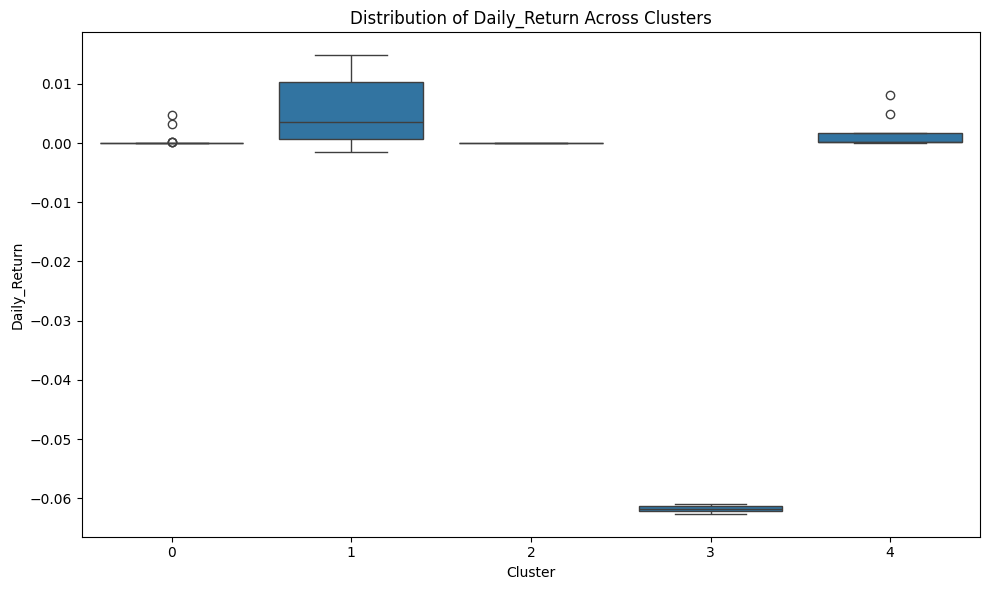

In [13]:
def plot_feature_boxplot(agg_data, feature):

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=agg_data)
    plt.title(f'Distribution of {feature} Across Clusters')
    plt.ylabel(f'{feature}')
    plt.xlabel('Cluster')
    plt.tight_layout()
    plt.show()

plot_feature_boxplot(agg_data, 'Daily_Return')


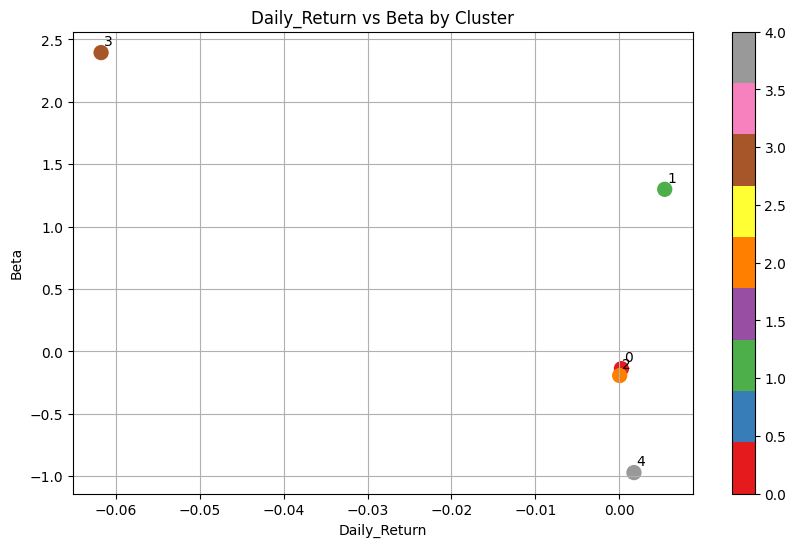

In [14]:
def plot_cluster_scatter(cluster_summary, feature_x, feature_y):

    plt.figure(figsize=(10, 6))

    plt.scatter(cluster_summary[feature_x], cluster_summary[feature_y], s=100, c=cluster_summary.index, cmap='Set1', label=cluster_summary.index)

    for i, label in enumerate(cluster_summary.index):
        plt.annotate(label, (cluster_summary[feature_x][i], cluster_summary[feature_y][i]), textcoords="offset points", xytext=(5,5), ha='center')

    plt.title(f'{feature_x} vs {feature_y} by Cluster')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.grid(True)
    plt.colorbar()
    plt.show()

plot_cluster_scatter(cluster_summary, 'Daily_Return', 'Beta')


In [15]:
stock_count_per_cluster = agg_data.groupby('Cluster').size()
print(stock_count_per_cluster)

Cluster
0    35
1     6
2     1
3     2
4     8
dtype: int64


In [16]:
for cluster in agg_data['Cluster'].unique():
    tickers_in_cluster = agg_data[agg_data['Cluster'] == cluster]['Ticker'].unique()
    print(f"Cluster {cluster}: {tickers_in_cluster}")

Cluster 2: ['9CI.SI']
Cluster 0: ['A17U.SI' 'AJBU.SI' 'ARKK' 'AW9U.SI' 'BN4.SI' 'C2PU.SI' 'C38U.SI'
 'C52.SI' 'C6L.SI' 'CEDU.SI' 'CJLU.SI' 'CY6U.SI' 'D01.SI' 'ES3.SI'
 'F34.SI' 'H78.SI' 'HMN.SI' 'J69U.SI' 'K71U.SI' 'LVMUY' 'M44U.SI'
 'MXNU.SI' 'N2IU.SI' 'O39.SI' 'O5RU.SI' 'OXMU.SI' 'Q5T.SI' 'S58.SI'
 'S63.SI' 'S68.SI' 'T82U.SI' 'TQ5.SI' 'U11.SI' 'U96.SI' 'Z74.SI']
Cluster 1: ['AAPL' 'AMD' 'AMZN' 'GOOGL' 'MSFT' 'NVDA']
Cluster 4: ['BABA' 'IVV' 'J36.SI' 'QQQ' 'RACE' 'SPY' 'VOO' 'VTI']
Cluster 3: ['SE' 'TSLA']


2b. Selection criteria based on clustering results - This is to choose the best objective for the portfolio.


In [17]:
def determine_criteria(kmeans):
    centroids = kmeans.cluster_centers_
    features = ['Daily_Return', 'Volume', 'Adj Close', 'Market Cap', 'Beta', 'P/E Ratio', 'PC1', 'PC2', 'PC3']
    centroid_df = pd.DataFrame(centroids, columns=features)

    avg_beta = centroid_df['Beta'].mean()
    avg_return = centroid_df['Daily_Return'].mean()

    if avg_beta < 1.0:
        return 'risk'
    elif avg_return > 0.05:
        return 'return'
    else:
        return 'balanced'

In [18]:
print(determine_criteria(kmeans))

risk


According to this, the code should be focused on risk minimisation

#3.Select stocks for risk minimization and return maximisation


In [19]:
def minimize_risk(aggregated_data, kmeans, n_min_stocks=10):
    if determine_criteria(kmeans) == 'risk':
        print("risk minimization strategy is optimal")
    else:
        print("Risk minimization not ideal, but proceeding as requested.")

    sorted_points = aggregated_data.sort_values(by='Beta', ascending=True).index  # Sort by Beta (low to high)
    representative_stocks = aggregated_data.iloc[sorted_points[:n_min_stocks]]['Ticker'].values
    return representative_stocks

def maximize_returns(aggregated_data, kmeans, n_min_stocks=10):
    if determine_criteria(kmeans) == 'return':
        print("return maximization strategyis optimal")
    else:
        print("Return maximization not ideal, but proceeding as requested.")

    sorted_points = aggregated_data.sort_values(by='Daily_Return', ascending=False).index  # Sort by Daily Return (high to low)
    representative_stocks = aggregated_data.iloc[sorted_points[:n_min_stocks]]['Ticker'].values
    return representative_stocks


In [20]:
low_risk_stocks_names = minimize_risk(agg_data, kmeans, n_min_stocks=10)
high_return_stocks_names = maximize_returns(agg_data, kmeans, n_min_stocks=10)

print("Low Risk Stocks:", low_risk_stocks_names)
print("High Return Stocks:", high_return_stocks_names)

risk minimization strategy is optimal
Return maximization not ideal, but proceeding as requested.
Low Risk Stocks: ['QQQ' 'IVV' 'VOO' 'SPY' 'ARKK' 'ES3.SI' 'VTI' 'CEDU.SI' 'S68.SI'
 'CJLU.SI']
High Return Stocks: ['AMD' 'GOOGL' 'BABA' 'AAPL' 'J36.SI' 'LVMUY' 'ARKK' 'AMZN' 'MSFT' 'QQQ']


**Stock names**

Low Risk Stocks: ['QQQ' 'IVV' 'VOO' 'SPY' 'ARKK' 'ES3.SI' 'VTI' 'CEDU.SI' 'S68.SI'
 'CJLU.SI']

High Return Stocks: ['AMD' 'GOOGL' 'BABA' 'AAPL' 'J36.SI' 'LVMUY' 'ARKK' 'AMZN' 'MSFT' 'QQQ']

In [21]:
def save_selected_stocks(data, selected_stocks, file_name):
    filtered_data = data[data['Ticker'].isin(selected_stocks)]
    filtered_data.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

save_selected_stocks(data, low_risk_stocks_names, "low_risk_stocks.csv")
save_selected_stocks(data, high_return_stocks_names, "high_return_stocks.csv")



Data saved to low_risk_stocks.csv
Data saved to high_return_stocks.csv


In [22]:
low_risk_stocks_raw = pd.read_csv('low_risk_stocks.csv')
high_return_stocks_raw = pd.read_csv('high_return_stocks.csv')


#4. Portfolio construction

**4a. Equally weighted portfolio**

In [23]:
num_stocks_low_risk=len(low_risk_stocks_names)
print(num_stocks_low_risk)

10


In [24]:
num_stocks_high_return=len(high_return_stocks_names)
print(num_stocks_high_return)

10


In [25]:
def equally_weighted_portfolio(stock_list, num_stocks):
    weights = np.ones(num_stocks) / num_stocks
    return weights


In [26]:
print(low_risk_stocks_raw.shape)

(11728, 29)


In [27]:
weights_ew_low_risk = equally_weighted_portfolio(low_risk_stocks_raw, num_stocks_low_risk)
weights_ew_high_return = equally_weighted_portfolio(high_return_stocks_raw,num_stocks_high_return)

print("Equal Weights for risk minimimisation Portfolio:", weights_ew_low_risk)
print("Equal Weights for return maximisation Portfolio:", weights_ew_high_return)

Equal Weights for risk minimimisation Portfolio: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Equal Weights for return maximisation Portfolio: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


**4b. Market cap weighted portfolio**

In [28]:
def market_cap_weighted_portfolio(stock_list):
    aggregated_stock_list = stock_list.groupby('Ticker')['Market Cap'].mean().reset_index()

    market_caps = aggregated_stock_list['Market Cap'].values
    total_market_cap = np.sum(market_caps)

    weights = market_caps / total_market_cap
    return weights


In [29]:
weights_mcw_low_risk = market_cap_weighted_portfolio(low_risk_stocks_raw)
weights_mcw_high_return = market_cap_weighted_portfolio(high_return_stocks_raw)

print("Market Cap Weights for risk minimimisation Portfolio:", weights_mcw_low_risk)
print("Market Cap Weights for return maximisation Portfolio:", weights_mcw_high_return)

Market Cap Weights for risk minimimisation Portfolio: [6.23834429e-16 2.00743182e-03 2.22442373e-01 6.23834429e-16
 6.23834429e-16 6.23834429e-16 7.75550195e-01 6.23834429e-16
 6.23834429e-16 6.23834429e-16]
Market Cap Weights for return maximisation Portfolio: [2.99164468e-01 2.24898050e-02 1.69013557e-01 8.69836200e-19
 2.35811812e-02 1.79472884e-01 8.90942340e-04 3.33888895e-02
 2.71998273e-01 8.69836200e-19]


**covariance calculation**

In [30]:
data_gvm=pd.read_csv('/content/financial_input_data.csv')

save_selected_stocks(data_gvm, low_risk_stocks_names, "low_risk_stocks_cov.csv")
save_selected_stocks(data_gvm, high_return_stocks_names, "high_return_stocks_cov.csv")

low_risk_stocks_gvm = pd.read_csv('low_risk_stocks_cov.csv')
high_return_stocks_gvm = pd.read_csv('high_return_stocks_cov.csv')

low_risk_stocks_gvm['Daily_Return'] = (low_risk_stocks_gvm['Close'] - low_risk_stocks_gvm['Open']) / low_risk_stocks_gvm['Open']
high_return_stocks_gvm['Daily_Return'] = (high_return_stocks_gvm['Close'] - high_return_stocks_gvm['Open']) / high_return_stocks_gvm['Open']

returns_low_risk = low_risk_stocks_gvm.pivot_table(index='Date_x', columns='Ticker', values='Daily_Return')
returns_low_risk = low_risk_stocks_gvm.pivot_table(index='Date_x', columns='Ticker', values='Daily_Return')
returns_high_return = high_return_stocks_gvm.pivot_table(index='Date_x', columns='Ticker', values='Daily_Return')


Data saved to low_risk_stocks_cov.csv
Data saved to high_return_stocks_cov.csv


In [31]:
print("Low-Risk Returns Data (pivoted):")
print(returns_low_risk.head())
print(returns_low_risk.tail())
print(returns_low_risk.shape)

Low-Risk Returns Data (pivoted):
Ticker          ARKK   CEDU.SI   CJLU.SI    ES3.SI       IVV       QQQ  \
Date_x                                                                   
2020-01-02 -0.002765  0.005952 -0.005291  0.006086  0.004123  0.008209   
2020-01-03  0.007841  0.000000 -0.005319 -0.006048  0.003969  0.004126   
2020-01-06  0.020194  0.000000  0.005319 -0.003966  0.009941  0.014400   
2020-01-07  0.009475  0.000000 -0.005291  0.004268 -0.000801 -0.000510   
2020-01-08  0.023087  0.005952 -0.005319  0.012592  0.004532  0.007657   

Ticker        S68.SI       SPY       VOO       VTI  
Date_x                                              
2020-01-02 -0.004494  0.004111  0.003801  0.001822  
2020-01-03 -0.028058  0.003892  0.003455  0.003919  
2020-01-06 -0.003472  0.009829  0.009952  0.009637  
2020-01-07 -0.003448 -0.000898 -0.000977 -0.001035  
2020-01-08 -0.002326  0.004676  0.004550  0.004324  
Ticker          ARKK   CEDU.SI   CJLU.SI    ES3.SI       IVV       QQQ  \
Dat

In [32]:
print("High-Return Returns Data (pivoted):")
print(returns_high_return.head())

High-Return Returns Data (pivoted):
Ticker          AAPL       AMD      AMZN      ARKK      BABA     GOOGL  \
Date_x                                                                   
2020-01-02  0.013874  0.047802  0.012272 -0.002765  0.014635  0.015032   
2020-01-03  0.000942  0.011868  0.005615  0.007841  0.003004  0.010030   
2020-01-06  0.020457  0.007705  0.023054  0.020194  0.008144  0.034166   
2020-01-07 -0.004836 -0.022290  0.001239  0.009475 -0.000046 -0.003820   
2020-01-08  0.020292 -0.000418 -0.003198  0.023087  0.006463  0.007327   

Ticker        J36.SI     LVMUY      MSFT       QQQ  
Date_x                                              
2020-01-02  0.010762  0.002979  0.011588  0.008209  
2020-01-03 -0.000890  0.006788  0.001895  0.004126  
2020-01-06  0.003571  0.014883  0.012414  0.014400  
2020-01-07  0.002306 -0.003875 -0.010921 -0.000510  
2020-01-08  0.011311  0.010834  0.007299  0.007657  


In [33]:
cov_matrix_low_risk = returns_low_risk.cov()
cov_matrix_high_return = returns_high_return.cov()

**4c. Maximum sharpe ratio portfolio**

In [34]:
def maximum_sharpe_ratio(returns, risk_free_rate=0.01):
    cov_matrix = returns.cov()
    mean_returns = returns.mean()

    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    num_stocks = len(returns.columns)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(0, 1) for _ in range(num_stocks)]

    initial_guess = np.ones(num_stocks) / num_stocks
    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    return result.x

In [35]:
weights_msr_low_risk = maximum_sharpe_ratio(returns_low_risk)
weights_msr_high_return = maximum_sharpe_ratio(returns_high_return)

print("MSR Weights for risk minimimisation Portfolio", weights_msr_low_risk)
print("MSR Weights for return maximisation Portfolio", weights_msr_high_return)

MSR Weights for risk minimimisation Portfolio [0.00000000e+00 1.00000000e+00 4.31599201e-15 2.70616862e-15
 1.47104551e-15 3.74700271e-16 4.05231404e-15 9.85322934e-16
 1.31838984e-15 8.32667268e-16]
MSR Weights for return maximisation Portfolio [2.70484376e-17 1.00000000e+00 2.25196978e-16 0.00000000e+00
 0.00000000e+00 6.77727471e-19 0.00000000e+00 1.22293407e-16
 0.00000000e+00 5.39113334e-17]


covariance matrix --> maximum sharpe ratio weight calculation

**GVM Portfolio**

In [36]:
num_stocks=10

In [37]:
initial_guess = np.random.dirichlet(np.ones(num_stocks))


In [38]:
def global_minimum_variance(returns):
    cov_matrix = returns.cov()

    def portfolio_variance(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    num_stocks = len(returns.columns)

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    bounds = [(0, 1) for _ in range(num_stocks)]

    initial_guess = np.ones(num_stocks) / num_stocks

    result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,), bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print("Optimization failed:", result.message)
        return np.ones(num_stocks)

In [39]:
scaler = StandardScaler()
returns_low_risk_scaled = pd.DataFrame(scaler.fit_transform(returns_low_risk), columns=returns_low_risk.columns)

weights_gmv_low_risk = global_minimum_variance(returns_low_risk_scaled)

print(" GMV Weights for risk minimimisation Portfolio:", weights_gmv_low_risk)

 GMV Weights for risk minimimisation Portfolio: [1.48987107e-01 2.35121660e-01 1.81784101e-01 1.39061775e-01
 5.35595873e-17 2.59797673e-02 1.39551449e-01 1.29514140e-01
 0.00000000e+00 0.00000000e+00]


In [40]:
scaler = StandardScaler()
returns_high_return_scaled = pd.DataFrame(scaler.fit_transform(returns_high_return), columns=returns_high_return.columns)

weights_gmv_high_return = global_minimum_variance(returns_high_return_scaled)

print(" GMV Weights for return maximisation Portfolio:", weights_gmv_high_return)

 GMV Weights for return maximisation Portfolio: [7.52024976e-02 9.41861853e-02 2.48021311e-02 4.72236472e-02
 1.48112801e-01 7.26005526e-02 3.66179783e-01 1.71692402e-01
 0.00000000e+00 1.51110678e-18]


**Visualising the model**

In [41]:
def calculate_portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility


In [42]:
def plot_portfolios(returns_low_risk, returns_high_return,
                    weights_ew_low_risk, weights_ew_high_return,
                    weights_mcw_low_risk, weights_mcw_high_return,
                    weights_gmv_low_risk, weights_gmv_high_return,
                    weights_msr_low_risk, weights_msr_high_return):

    portfolios = ['Equally Weighted', 'Market-Cap Weighted', 'Global Minimum Variance', 'Maximum Sharpe Ratio']

    mean_returns_low_risk = returns_low_risk.mean()
    cov_matrix_low_risk = returns_low_risk.cov()

    mean_returns_high_return = returns_high_return.mean()
    cov_matrix_high_return = returns_high_return.cov()

    # Low-Risk Portfolios
    portfolio_performance_low_risk = {
        'Equally Weighted': calculate_portfolio_performance(weights_ew_low_risk, mean_returns_low_risk, cov_matrix_low_risk),
        'Market-Cap Weighted': calculate_portfolio_performance(weights_mcw_low_risk, mean_returns_low_risk, cov_matrix_low_risk),
        'Global Minimum Variance': calculate_portfolio_performance(weights_gmv_low_risk, mean_returns_low_risk, cov_matrix_low_risk),
        'Maximum Sharpe Ratio': calculate_portfolio_performance(weights_msr_low_risk, mean_returns_low_risk, cov_matrix_low_risk)
    }

    # High-Return Portfolios
    portfolio_performance_high_return = {
        'Equally Weighted': calculate_portfolio_performance(weights_ew_high_return, mean_returns_high_return, cov_matrix_high_return),
        'Market-Cap Weighted': calculate_portfolio_performance(weights_mcw_high_return, mean_returns_high_return, cov_matrix_high_return),
        'Global Minimum Variance': calculate_portfolio_performance(weights_gmv_high_return, mean_returns_high_return, cov_matrix_high_return),
        'Maximum Sharpe Ratio': calculate_portfolio_performance(weights_msr_high_return, mean_returns_high_return, cov_matrix_high_return)
    }

    # Plotting Low-Risk Portfolios
    plt.figure(figsize=(14, 8))
    for i, portfolio in enumerate(portfolios):
        ret, vol = portfolio_performance_low_risk[portfolio]
        plt.scatter(vol, ret, label=f'{portfolio} (Low Risk)', marker='o', s=100)
        plt.text(vol, ret, portfolio, fontsize=12)

    # Plotting High-Return Portfolios
    for i, portfolio in enumerate(portfolios):
        ret, vol = portfolio_performance_high_return[portfolio]
        plt.scatter(vol, ret, label=f'{portfolio} (High Return)', marker='x', s=100)
        plt.text(vol, ret, portfolio, fontsize=12)

    plt.title('Portfolio Returns vs Volatility')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print("Low-Risk Portfolio Performance:")
    for portfolio, (ret, vol) in portfolio_performance_low_risk.items():
        print(f"{portfolio} - Return: {ret:.4f}, Volatility: {vol:.4f}")

    print("\nHigh-Return Portfolio Performance:")
    for portfolio, (ret, vol) in portfolio_performance_high_return.items():
        print(f"{portfolio} - Return: {ret:.4f}, Volatility: {vol:.4f}")


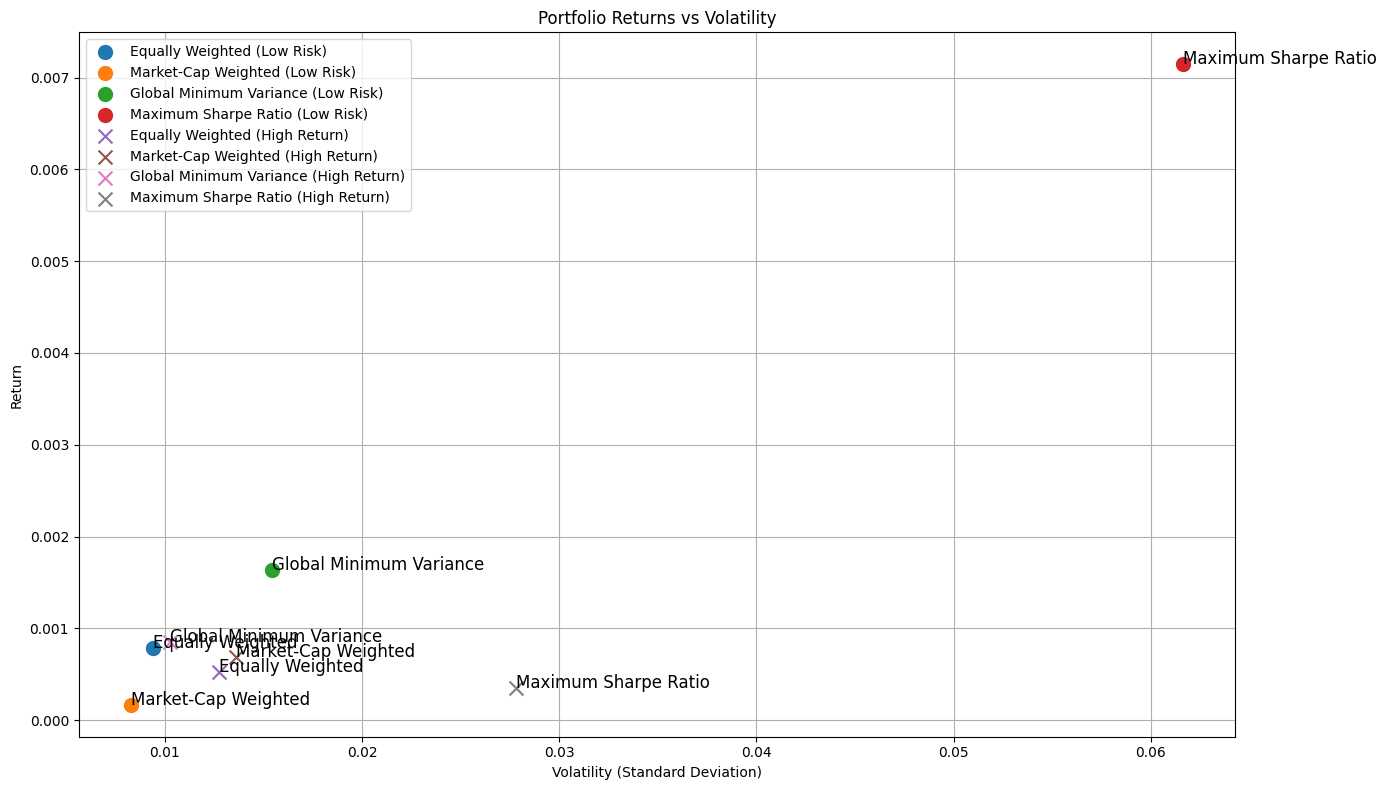

In [43]:
plot_portfolios(returns_low_risk, returns_high_return,
                weights_ew_low_risk, weights_ew_high_return,
                weights_mcw_low_risk, weights_mcw_high_return,
                weights_gmv_low_risk, weights_gmv_high_return,
                weights_msr_low_risk, weights_msr_high_return)


Low-Risk Portfolio Performance:
Equally Weighted - Return: 0.0008, Volatility: 0.0094
Market-Cap Weighted - Return: 0.0002, Volatility: 0.0083
Global Minimum Variance - Return: 0.0016, Volatility: 0.0154
Maximum Sharpe Ratio - Return: 0.0071, Volatility: 0.0616

High-Return Portfolio Performance:
Equally Weighted - Return: 0.0005, Volatility: 0.0127
Market-Cap Weighted - Return: 0.0007, Volatility: 0.0136
Global Minimum Variance - Return: 0.0009, Volatility: 0.0103
Maximum Sharpe Ratio - Return: 0.0003, Volatility: 0.0278


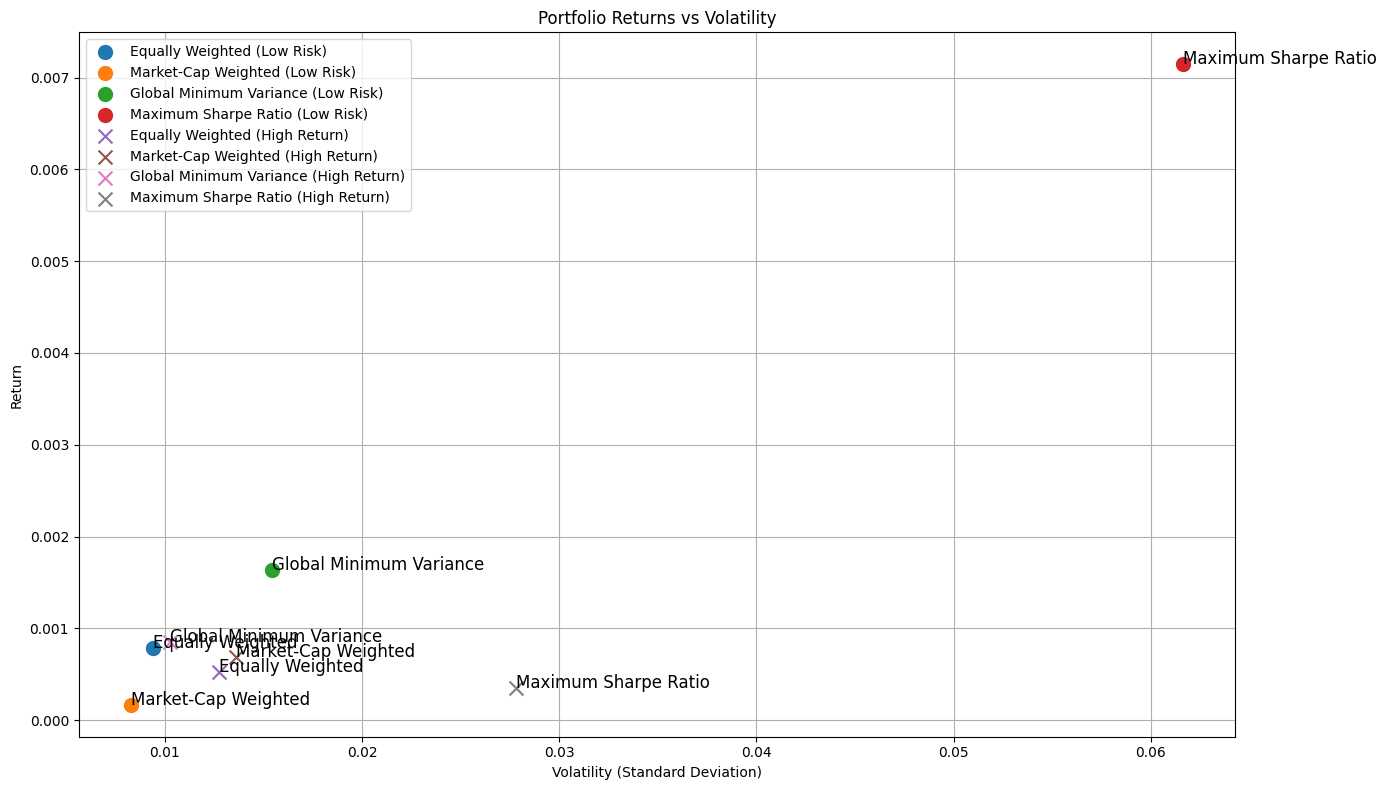

Low-Risk Portfolio Performance:
Equally Weighted - Return: 0.0008, Volatility: 0.0094
Market-Cap Weighted - Return: 0.0002, Volatility: 0.0083
Global Minimum Variance - Return: 0.0016, Volatility: 0.0154
Maximum Sharpe Ratio - Return: 0.0071, Volatility: 0.0616

High-Return Portfolio Performance:
Equally Weighted - Return: 0.0005, Volatility: 0.0127
Market-Cap Weighted - Return: 0.0007, Volatility: 0.0136
Global Minimum Variance - Return: 0.0009, Volatility: 0.0103
Maximum Sharpe Ratio - Return: 0.0003, Volatility: 0.0278
Selected Portfolio for Risk Minimization: Market-Cap Weighted Low Risk
Return: 0.0002, Volatility: 0.0083
Selected Portfolio for Return Maximization: Maximum Sharpe Ratio Low Risk
Return: 0.0071, Volatility: 0.0616


In [44]:
plot_portfolios(returns_low_risk, returns_high_return,
                weights_ew_low_risk, weights_ew_high_return,
                weights_mcw_low_risk, weights_mcw_high_return,
                weights_gmv_low_risk, weights_gmv_high_return,
                weights_msr_low_risk, weights_msr_high_return)
portfolios = {
    'Equally Weighted Low Risk': calculate_portfolio_performance(weights_ew_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Market-Cap Weighted Low Risk': calculate_portfolio_performance(weights_mcw_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Global Minimum Variance Low Risk': calculate_portfolio_performance(weights_gmv_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Maximum Sharpe Ratio Low Risk': calculate_portfolio_performance(weights_msr_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),

    'Equally Weighted High Return': calculate_portfolio_performance(weights_ew_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Market-Cap Weighted High Return': calculate_portfolio_performance(weights_mcw_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Global Minimum Variance High Return': calculate_portfolio_performance(weights_gmv_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Maximum Sharpe Ratio High Return': calculate_portfolio_performance(weights_msr_high_return, returns_high_return.mean(), cov_matrix_high_return)
}
selected_risk_minimization_portfolio = min(portfolios.items(), key=lambda x: x[1][1])  # Select lowest volatility (index 1 is volatility)

selected_return_maximization_portfolio = max(portfolios.items(), key=lambda x: x[1][0])  # Select highest return (index 0 is return)

print(f"Selected Portfolio for Risk Minimization: {selected_risk_minimization_portfolio[0]}")
print(f"Return: {selected_risk_minimization_portfolio[1][0]:.4f}, Volatility: {selected_risk_minimization_portfolio[1][1]:.4f}")

print(f"Selected Portfolio for Return Maximization: {selected_return_maximization_portfolio[0]}")
print(f"Return: {selected_return_maximization_portfolio[1][0]:.4f}, Volatility: {selected_return_maximization_portfolio[1][1]:.4f}")


In [45]:
portfolios = {
    'Equally Weighted Low Risk': calculate_portfolio_performance(weights_ew_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Market-Cap Weighted Low Risk': calculate_portfolio_performance(weights_mcw_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Global Minimum Variance Low Risk': calculate_portfolio_performance(weights_gmv_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Maximum Sharpe Ratio Low Risk': calculate_portfolio_performance(weights_msr_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),

    'Equally Weighted High Return': calculate_portfolio_performance(weights_ew_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Market-Cap Weighted High Return': calculate_portfolio_performance(weights_mcw_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Global Minimum Variance High Return': calculate_portfolio_performance(weights_gmv_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Maximum Sharpe Ratio High Return': calculate_portfolio_performance(weights_msr_high_return, returns_high_return.mean(), cov_matrix_high_return)
}


In [46]:
portfolios_lr = {
    'Equally Weighted Low Risk': calculate_portfolio_performance(weights_ew_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Market-Cap Weighted Low Risk': calculate_portfolio_performance(weights_mcw_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Global Minimum Variance Low Risk': calculate_portfolio_performance(weights_gmv_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
    'Maximum Sharpe Ratio Low Risk': calculate_portfolio_performance(weights_msr_low_risk, returns_low_risk.mean(), cov_matrix_low_risk),
}

In [47]:
portfolios_hr = {
    'Equally Weighted High Return': calculate_portfolio_performance(weights_ew_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Market-Cap Weighted High Return': calculate_portfolio_performance(weights_mcw_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Global Minimum Variance High Return': calculate_portfolio_performance(weights_gmv_high_return, returns_high_return.mean(), cov_matrix_high_return),
    'Maximum Sharpe Ratio High Return': calculate_portfolio_performance(weights_msr_high_return, returns_high_return.mean(), cov_matrix_high_return)
}


In [48]:
selected_risk_minimization_portfolio = min(portfolios_lr.items(), key=lambda x: x[1][1])

selected_return_maximization_portfolio = max(portfolios_hr.items(), key=lambda x: x[1][0])

print(f"Selected Portfolio for Risk Minimization: {selected_risk_minimization_portfolio[0]}")
print(f"Return: {selected_risk_minimization_portfolio[1][0]:.4f}, Volatility: {selected_risk_minimization_portfolio[1][1]:.4f}")

print(f"Selected Portfolio for Return Maximization: {selected_return_maximization_portfolio[0]}")
print(f"Return: {selected_return_maximization_portfolio[1][0]:.4f}, Volatility: {selected_return_maximization_portfolio[1][1]:.4f}")


Selected Portfolio for Risk Minimization: Market-Cap Weighted Low Risk
Return: 0.0002, Volatility: 0.0083
Selected Portfolio for Return Maximization: Global Minimum Variance High Return
Return: 0.0009, Volatility: 0.0103


#Genetic algorithm

 The best solution found:
 [0.02834653 0.12008655 0.15293442 0.06864456 0.03435026 0.0208019
 0.01451853 0.09384017 0.24833479 0.21811214]

 Objective function:
 0.030243285482887978


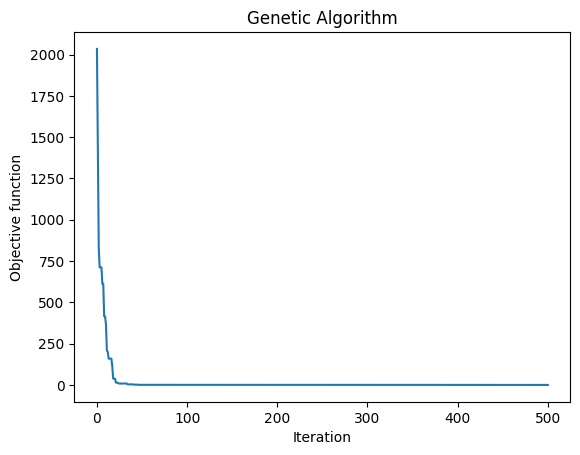

 The best solution found:
 [0.96945208 0.97537621 0.99286464 0.93782318 0.82639183 0.99293794
 0.95047655 0.99374907 0.95100978 0.98211162]

 Objective function:
 0.03954584016904102


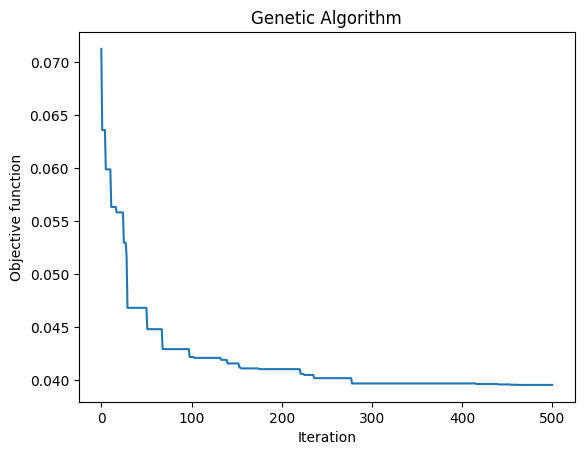

Optimized Weights for Risk Minimization (GA): [0.02834653 0.12008655 0.15293442 0.06864456 0.03435026 0.0208019
 0.01451853 0.09384017 0.24833479 0.21811214]
Optimized Weights for Return Maximization (GA): [0.96945208 0.97537621 0.99286464 0.93782318 0.82639183 0.99293794
 0.95047655 0.99374907 0.95100978 0.98211162]


In [63]:
from geneticalgorithm import geneticalgorithm as ga
import numpy as np

def risk_minimization_genetic(returns):

    cov_matrix = returns.cov()

    def fitness_function(weights):
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        sum_weights = np.sum(weights)
        penalty = 1000 * abs(sum_weights - 1)
        return portfolio_variance + penalty

    num_stocks = len(returns.columns)
    bounds = [(0, 1) for _ in range(num_stocks)]
    varbound = np.array(bounds)

    algorithm_param = {
        'max_num_iteration': 1000,
        'population_size': 100,
        'mutation_probability': 0.1,
        'elit_ratio': 0.01,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type': 'uniform'
    }

    model = ga(function=fitness_function, dimension=num_stocks, variable_type='real', variable_boundaries=varbound)
    model.run()

    return model.output_dict['variable']

def sharpe_ratio_maximization_genetic(returns, risk_free_rate=0.01):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    def fitness_function(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -((portfolio_return - risk_free_rate) / portfolio_volatility)

    num_stocks = len(returns.columns)
    bounds = [(0, 1) for _ in range(num_stocks)]
    varbound = np.array(bounds)

    algorithm_param = {
        'max_num_iteration': 1000,
        'population_size': 100,
        'mutation_probability': 0.1,
        'elit_ratio': 0.01,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type': 'uniform'
    }

    model = ga(function=fitness_function, dimension=num_stocks, variable_type='real', variable_boundaries=varbound)
    model.run()

    return model.output_dict['variable']

selected_returns_low_risk = returns_low_risk if 'Low Risk' in selected_risk_minimization_portfolio[0] else returns_high_return
selected_returns_high_return = returns_high_return if 'High Return' in selected_return_maximization_portfolio[0] else returns_low_risk

optimized_weights_risk_minimization = risk_minimization_genetic(selected_returns_low_risk)

optimized_weights_return_maximization = sharpe_ratio_maximization_genetic(selected_returns_high_return)

print("Optimized Weights for Risk Minimization (GA):", optimized_weights_risk_minimization)
print("Optimized Weights for Return Maximization (GA):", optimized_weights_return_maximization)


#LSTM

In [50]:
financial_data = pd.read_csv('financial_input_data.csv')

low_risk_stocks_data = financial_data[financial_data['Ticker'].isin(low_risk_stocks_names)]

high_return_stocks_data = financial_data[financial_data['Ticker'].isin(high_return_stocks_names)]


In [51]:
low_risk_weights = [0.05113606, 0.04620593, 0.08319142, 0.00123659, 0.03726708, 0.0004024, 0.04294167, 0.06268319, 0.02200696, 0.00822356]

high_return_weights = [0.04410116, 0.99138013, 0.96658837, 0.01229026, 0.95111988, 0.997677, 0.97444052, 0.99232258, 0.99455734, 0.91662708]

low_risk_stocks_data.loc[:, 'Weight'] = low_risk_stocks_data['Ticker'].map(dict(zip(low_risk_stocks_names, low_risk_weights[:len(low_risk_stocks_names)])))

high_return_stocks_data.loc[:, 'Weight'] = high_return_stocks_data['Ticker'].map(dict(zip(high_return_stocks_names, high_return_weights[:len(high_return_stocks_names)])))


<ipython-input-51-1ef4dc656da7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_stocks_data.loc[:, 'Weight'] = low_risk_stocks_data['Ticker'].map(dict(zip(low_risk_stocks_names, low_risk_weights[:len(low_risk_stocks_names)])))
<ipython-input-51-1ef4dc656da7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_return_stocks_data.loc[:, 'Weight'] = high_return_stocks_data['Ticker'].map(dict(zip(high_return_stocks_names, high_return_weights[:len(high_return_stocks_names)])))


In [52]:
import numpy as np

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)


Train LSTM for Low-Risk Portfolio

In [53]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Weight']

scaler = MinMaxScaler()
low_risk_stocks_data.loc[:, 'Emphasized_Weight'] = low_risk_stocks_data['Weight'] * 10  # Example of emphasizing the weight

low_risk_scaled_data = scaler.fit_transform(low_risk_stocks_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Emphasized_Weight']])

sequence_length = 60
X_low_risk, y_low_risk = create_sequences(low_risk_scaled_data, sequence_length)

X_low_risk = X_low_risk.reshape((X_low_risk.shape[0], sequence_length, len(features)))


<ipython-input-53-1239b89eb642>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_stocks_data.loc[:, 'Emphasized_Weight'] = low_risk_stocks_data['Weight'] * 10  # Example of emphasizing the weight


In [54]:
from tensorflow.keras.optimizers import Adam

scaler = MinMaxScaler()
X_low_risk_scaled = scaler.fit_transform(X_low_risk.reshape(-1, X_low_risk.shape[-1])).reshape(X_low_risk.shape)

model_low_risk = Sequential()
model_low_risk.add(LSTM(units=50, return_sequences=True, input_shape=(X_low_risk_scaled.shape[1], X_low_risk_scaled.shape[2])))
model_low_risk.add(Dropout(0.2))
model_low_risk.add(LSTM(units=50, return_sequences=False))
model_low_risk.add(Dropout(0.2))
model_low_risk.add(Dense(units=25, activation='relu'))
model_low_risk.add(Dense(units=1))

optimizer = Adam(learning_rate=0.0005)
model_low_risk.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history = model_low_risk.fit(
    X_low_risk_scaled,
    y_low_risk,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - loss: 0.0723 - mae: 0.1765 - mse: 0.0723 - val_loss: 0.0216 - val_mae: 0.1025 - val_mse: 0.0216
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 0.0489 - mae: 0.1443 - mse: 0.0489 - val_loss: 0.0217 - val_mae: 0.1047 - val_mse: 0.0217
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 0.0489 - mae: 0.1443 - mse: 0.0489 - val_loss: 0.0216 - val_mae: 0.1050 - val_mse: 0.0216
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.0480 - mae: 0.1420 - mse: 0.0480 - val_loss: 0.0218 - val_mae: 0.1099 - val_mse: 0.0218
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.0488 - mae: 0.1441 - mse: 0.0488 - val_loss: 0.0216 - val_mae: 0.1073 - val_mse: 0.0216
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 0.0481 - mae: 0.1424 - mse: 0.0481 - val_loss: 0.0217 - val_mae: 0.1102 - val_mse: 0.0217
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0481 - mae: 0.1426 - mse

Train LSTM for High-Return Portfolio

In [55]:
high_return_stocks_data.loc[:, 'Emphasized_Weight'] = high_return_stocks_data['Weight'] * 10  # Example of emphasizing the weight

high_return_scaled_data = scaler.fit_transform(high_return_stocks_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Emphasized_Weight']])

X_high_return, y_high_return = create_sequences(high_return_scaled_data, sequence_length)

X_high_return = X_high_return.reshape((X_high_return.shape[0], sequence_length, len(features)))


<ipython-input-55-9897e7c4dcab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_return_stocks_data.loc[:, 'Emphasized_Weight'] = high_return_stocks_data['Weight'] * 10  # Example of emphasizing the weight


In [56]:
from tensorflow.keras.optimizers import Adam

scaler = MinMaxScaler()
X_high_return_scaled = scaler.fit_transform(X_high_return.reshape(-1, X_high_return.shape[-1])).reshape(X_high_return.shape)

model_high_return = Sequential()
model_high_return.add(LSTM(units=50, return_sequences=True, input_shape=(X_high_return_scaled.shape[1], X_high_return_scaled.shape[2])))
model_high_return.add(Dropout(0.2))
model_high_return.add(LSTM(units=50, return_sequences=False))
model_high_return.add(Dropout(0.2))
model_high_return.add(Dense(units=25, activation='relu'))
model_high_return.add(Dense(units=1))

optimizer = Adam(learning_rate=0.0005)
model_high_return.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history = model_high_return.fit(
    X_high_return_scaled,
    y_high_return,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - loss: 0.0838 - mae: 0.1981 - mse: 0.0838 - val_loss: 0.0913 - val_mae: 0.2224 - val_mse: 0.0913
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - loss: 0.0742 - mae: 0.1838 - mse: 0.0742 - val_loss: 0.0910 - val_mae: 0.2249 - val_mse: 0.0910
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 0.0737 - mae: 0.1831 - mse: 0.0737 - val_loss: 0.0910 - val_mae: 0.2212 - val_mse: 0.0910
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.0739 - mae: 0.1834 - mse: 0.0739 - val_loss: 0.0901 - val_mae: 0.2162 - val_mse: 0.0901
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.0744 - mae: 0.1838 - mse: 0.0744 - val_loss: 0.0908 - val_mae: 0.2207 - val_mse: 0.0908
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.0744 - mae: 0.1837 - mse: 0.0744 - val_loss: 0.0904 - val_mae: 0.2212 - val_mse: 0.0904
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.0739 - mae: 0.1830 - mse

In [57]:
model_high_return.save('content/model_high_return.h5')


In [58]:
model_low_risk.save('content/model_low_risk.h5')


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
model_high_return.save_weights('model_high_return_weights.weights.h5')


In [62]:
model_low_risk.save_weights('model_low_risk_weights.weights.h5')


weights normalisation

In [67]:
total_weight = sum(high_return_weights)
print(f"Total Weight Before Normalization: {total_weight}")
normalized_weights = [weight / total_weight for weight in high_return_weights]

sum_normalized = sum(normalized_weights)
print(f"Sum of Normalized Weights: {sum_normalized}")

print("Normalized Weights:")
for i, weight in enumerate(normalized_weights, 1):
    print(f"Weight {i}: {weight:.6f}")

Total Weight Before Normalization: 7.8411043199999995
Sum of Normalized Weights: 1.0
Normalized Weights:
Weight 1: 0.005624
Weight 2: 0.126434
Weight 3: 0.123272
Weight 4: 0.001567
Weight 5: 0.121299
Weight 6: 0.127237
Weight 7: 0.124273
Weight 8: 0.126554
Weight 9: 0.126839
Weight 10: 0.116900


In [76]:
total_weight = sum(low_risk_weights)
print(f"Total Weight Before Normalization: {total_weight}")
normalized_weights = [weight / total_weight for weight in low_risk_weights]

sum_normalized = sum(normalized_weights)
print(f"Sum of Normalized Weights: {sum_normalized}")

print("Normalized Weights:")
for i, weight in enumerate(normalized_weights, 1):
    print(f"Weight {i}: {weight:.6f}")

Total Weight Before Normalization: 0.35529486000000005
Sum of Normalized Weights: 1.0
Normalized Weights:
Weight 1: 0.143926
Weight 2: 0.130050
Weight 3: 0.234148
Weight 4: 0.003480
Weight 5: 0.104891
Weight 6: 0.001133
Weight 7: 0.120862
Weight 8: 0.176426
Weight 9: 0.061940
Weight 10: 0.023146
